# Malware classification system - Cirillo & Straziota

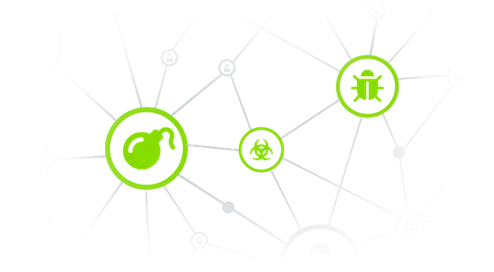

In [4]:
import pandas as pd
import os
import numpy as np
from pprint import pprint
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import svm


# Introduzione

In un'epoca in cui la nostra vita quotidiana è dominata dai dispositivi mobili e le applicazioni Android sono diventate una parte essenziale del nostro modo di interagire con il mondo digitale, la sicurezza dei dispositivi è diventata una preoccupazione sempre più rilevante.

Il proliferare dei malware Android ha reso fondamentale l'identificazione e la classificazione accurata di tali minacce per proteggere gli utenti da possibili danni. È qui che entra in gioco il machine learning, un potente strumento che ci consente di creare modelli intelligenti capaci di distinguere tra applicazioni legittime e malware dannosi.

Il progetto ha l'obiettivo di sviluppare un modello di machine learning che possa analizzare in modo efficiente e accurato il traffico di rete di applicazioni Android, al fine di classificarle come "legittime" o "malware". Questo processo richiede un'ampia raccolta di dati sul traffico delle applicazioni, compresi sia campioni di traffico di malware noti che traffico di applicazioni affidabili, in modo da addestrare i vari modelli a riconoscere le features discriminanti delle minacce.

Attraverso l'uso di algoritmi di machine learning avanzati, come reti neurali artificiali o algoritmi di apprendimento supervisionato, i modelli impareranno da questi dati di addestramento per identificare segnali, pattern e comportamenti sospetti che sono tipici dei malware Android. Una volta addestrato, il modello potrà essere utilizzato per analizzare il traffico di rete di nuove applicazioni e classificarle con una precisione elevata.

La ricerca e lo sviluppo di questo modello di classificazione di malware Android sono essenziali per la difesa delle persone e dei loro dispositivi mobili. Questa creazione potrebbe contribuire significativamente a rafforzare la sicurezza delle app Android e a garantire una migliore esperienza di utilizzo per gli utenti di tutto il mondo.

Nella prossima cella, carichiamo il dataset da una collezione di file `CSV` che contengono, rispettivamente, traffico di rete di applicazioni legalmente scaricate da play store e applicazioni scaricate invece da fonti alternative che corrispondo a malware, in particolare a 
- [Ransomware](#ransomware)
- [Adware](#adware)
- [Scareware](#scareware)
- [SMSmalware](#smsmalware)

## Ransomware
<img src="img/ransomware.webp" style="width: 50%; display:block">

Il [ransomware](https://www.garanteprivacy.it/temi/cybersecurity/ransomware) è un programma informatico dannoso ("malevolo") che può “infettare” un dispositivo digitale (PC, tablet, smartphone, smart TV), bloccando l’accesso a tutti o ad alcuni dei suoi contenuti (foto, video, file, ecc.) per poi chiedere un riscatto (in inglese, “ransom”) da pagare per “liberarli”.

La richiesta di pagamento, con le relative istruzioni, compare di solito in una finestra che si apre automaticamente sullo schermo del dispositivo infettato. All’utente viene minacciosamente comunicato che ha poche ore o pochi giorni per effettuare il versamento del riscatto, altrimenti il blocco dei contenuti diventerà definitivo.

Ci sono due tipi principali di ransomware:
- i cryptor (che criptano i file contenuti nel dispositivo rendendoli inaccessibili);
- i blocker (che bloccano l’accesso al dispositivo infettato).

Ad esempio, nel nostro dataset è presente traffico di rete di un di tipo di ransomware: un trojan mobile, chiamato *Simplocker*:
### Simplocker
<img src="img/simplocker.webp" style="width: 50%; display:block">
Simplocker è un trojan mobile, uno dei primi del suo genere, che si rivolge ai dispositivi mobili Android. Questo malware esegue la scansione della scheda SD residente per determinati tipi di file (.jpeg, .jpg, .png, .bmp, .gif, .pdf, .doc, .docx, .txt, .avi, .mkv, .3gp, .mp4), crittografa questi file utilizzando AES, e poi chiede un riscatto all'utente in cambio della decrittografia di questi file riscattati. Il risultato è che, fino a quando questo riscatto non viene pagato, gli utenti non sono in grado di accedere ai loro file personali (immagini, download, canzoni, ecc.).

## Adware
<img src="img/adware.jpg" style="width: 50%; display:block">
L'Adware è un software indesiderato progettato per lanciare messaggi pubblicitari sullo schermo, spesso all'interno di un browser web. Alcuni professionisti della sicurezza li considerano i precursori del moderno PUP (programma potenzialmente indesiderato). Gli adware si avvalgono in genere di un metodo subdolo, mascherandosi da componenti legittimi o causando il trasferimento su un altro programma al fine di provocarne con l'inganno l'installazione su PC, tablet o dispositivo mobile.

In particolare, come esempio di adware, consideriamo [Mobidash](https://www.malwarebytes.com/blog/detections/android-adware-mobidash):
### MobiDash
<img src="img/MobiDash.png" style="width: 50%; display:block">
Android/Adware.MobiDash è il nome di detection per adware che prende di mira i dispositivi mobili che eseguono il sistema operativo Android. Si presenta sotto forma di un Ad SDK che può essere facilmente aggiunto a qualsiasi APK. Molte volte, un APK legittimo viene preso e riconfezionato con Ad SDK. MobiDash visualizza gli annunci pop-up dopo lo sblocco dello schermo. Una caratteristica unica di MobiDash è che attende circa tre giorni dopo l'installazione per visualizzare gli annunci. MobiDash è diventato prevalente nel 2015 e continua a diffondersi attraverso centinaia di varianti.

Ha utilizzato la popolarità di FaceApp per diffondersi. La società di sicurezza Kaspersky ha scoperto l’adware il 7 luglio quando gli utenti hanno riferito che dopo aver scaricato il virale FaceApp da fonti non ufficiali l’applicazione non si è riuscita a installare. Quando gli utenti installano MobiDash pensando che sia FaceApp, sono portati a credere che l’applicazione non sia stata installata. I segni evidenti dell’applicazione installata sul dispositivo scompaiono, ma un modulo dannoso rimane ancora e visualizza silenziosamente pubblicità. Kaspersky ha riferito che almeno 500 dispositivi sono stati infettati entro un periodo di 48 ore a partire dal 19 luglio.

## Scareware
<img src="img/scareware.jpg" style="width: 50%; display:block">
Lo scareware è un tipo di malware che utilizza il social engineering per generare panico o preoccupazioni o per convincere gli utenti che sussiste una minaccia specifica per indurli a installare o acquistare software non richiesti. Questa minaccia è connessa a falsi programmi o software antivirus per la disinfezione e il ripristino.
Nella maggior parte dei casi, il virus menzionato è fittizio e il software consigliato non funziona o installa il vero malware. Gli scareware possono anche essere applicazioni o virus progettati per ingannare gli utenti e causare panico o preoccupazione.

Un esempio di scareware che possiamo trovare nel nostro dataset è [FakeApp](###FakeApp)

### FakeApp
<img src="img/FakeApp.jpeg" style="width: 20%; display: block">
Android/FakeApp si maschera come un'app legittima che afferma di eseguire varie azioni come essere un'app antivirus, un aggiornamento e altre app. La vera intenzione è spesso quella di guadagnare entrate attraverso la visualizzazione di annunci e il reindirizzamento degli utenti per installare altre app, per lo più app legittime tramite Google Play. Tuttavia, le varianti Android/FakeApp sono state viste svolgere attività più dannose come l'invio/ricezione di messaggi SMS e il download/drop di altre app.

## SMSmalware
<img src="img/smsmalware.jpg" style="width: 50%; display:block">
Questi trojan utilizzano i servizi di messaggistica SMS (text) di un dispositivo mobile per inviare e intercettare messaggi. L'utente di solito non è a conoscenza del comportamento.

### FakeNotify
<img src="img/fakenotify.jpg" style="width: 20%; display:block">
Trojan:Android/FakeNotify è un cavallo di Troia per dispositivi Android che si traveste da applicazione che fornisce notifiche di aggiornamento; quando viene eseguita, tuttavia, l'app invia silenziosamente messaggi SMS a numeri premium, raccoglie e invia informazioni e reindirizza quindi l'utente a un sito web non richiesto.

In [5]:
def tryconvert(x, to_type, default):
  '''
  Try convert `x` to a type specified by `to_type` function. 
  Returns `default` value if casting is not possibile 
  '''
  try:
    return to_type(x)
  except:
    return default

def load_data(directory, nrows=None, usecols=None, converters=None, dtype=None):
# Read each CSV file in dir "path/to/root_dir"
    dfs = []
    for file in Path(directory).glob('**/*.csv'):
        dfs.append(pd.read_csv(file, nrows=nrows, usecols=usecols, converters=converters, dtype=dtype))
    # Put the dataframes to a single dataframe
    df = pd.concat(dfs, ignore_index=True)
    return df

benign_dir = os.path.join(os.getcwd(), 'dataset', 'Benign')
malware_dir = os.path.join(os.getcwd(), 'dataset', 'Malware')

# usecols = [" Total Length of Bwd Packets", " Fwd Packet Length Std", " Bwd Packet Length Min", " Bwd Packet Length Std", " Flow IAT Mean", " Flow IAT Min", "Init_Win_bytes_forward", " Init_Win_bytes_backward", " min_seg_size_forward", " Label"]
usecols = None

# Define column datatype when reading CSVs
if usecols:
  converters = dict(itertools.product(usecols, [lambda x: tryconvert(x, float, np.nan)]))
  converters[" Label"] = lambda x: x
else:
   converters = None

# Load data
N_rows = 1000
benign_df = load_data(benign_dir, nrows=None, usecols=usecols, converters=converters)
malware_df = load_data(malware_dir, nrows=None, usecols=usecols, converters=converters)

df = pd.concat([benign_df, malware_df], ignore_index=True)

# shuffle dataset
#df = df.sample(frac=1).reset_index(drop=True)

# trim columns labels
df.columns = df.columns.str.strip()

# Drop rows which contain NaN values
df.dropna(inplace=True)

# Drop empty label rows
df.drop(df[df["Label"] == ''].index, inplace = True)

# Change Label values in "MALWARE" or "BENIGN"
df["Label"] = df["Label"].apply(lambda x: 'MALWARE' if x != 'BENIGN' else x)
df

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,10.42.0.42-108.174.10.10-45599-80-6,10.42.0.42,45599.0,108.174.10.10,80.0,6.0,22/06/2017 11:19:51,210533.0,3.0,4.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,10.42.0.42-108.174.10.10-45599-80-6,10.42.0.42,45599.0,108.174.10.10,80.0,6.0,22/06/2017 11:19:51,142284.0,2.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,172.217.11.10-10.42.0.42-443-48822-6,10.42.0.42,48822.0,172.217.11.10,443.0,6.0,22/06/2017 11:19:56,37530.0,1.0,2.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,172.217.12.174-10.42.0.42-443-39917-6,10.42.0.42,39917.0,172.217.12.174,443.0,6.0,22/06/2017 11:19:57,36739.0,1.0,2.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,10.42.0.42-52.37.10.236-54948-80-6,10.42.0.42,54948.0,52.37.10.236,80.0,6.0,22/06/2017 11:20:07,289279.0,2.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2616574,10.42.0.151-10.42.0.1-8300-53-17,10.42.0.151,8300.0,10.42.0.1,53.0,17.0,14/06/2017 12:44:29,400167.0,1.0,1.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MALWARE
2616575,172.217.2.174-10.42.0.151-443-44967-6,10.42.0.151,44967.0,172.217.2.174,443.0,6.0,14/06/2017 12:49:41,60072632.0,3.0,1.0,...,32.0,118314.0,0.0,118314.0,118314.0,59932174.0,0.0,59932174.0,59932174.0,MALWARE
2616576,10.42.0.151-31.13.71.37-39170-443-6,31.13.71.37,443.0,10.42.0.151,39170.0,6.0,14/06/2017 12:32:50,6714.0,2.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MALWARE
2616577,10.42.0.151-10.42.0.1-55323-53-17,10.42.0.151,55323.0,10.42.0.1,53.0,17.0,14/06/2017 12:40:44,92288.0,1.0,1.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MALWARE


Proviamo a ridurre la dimensionalità del nostro dataset applicando una PCA:
# Data dimensionality reduction

In [7]:
# Use PCA for dimensionality reduction and plot the results
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Separating out the features
x = df.iloc[:, :-1].values
# Separating out the target
y = df.iloc[:, -1:].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

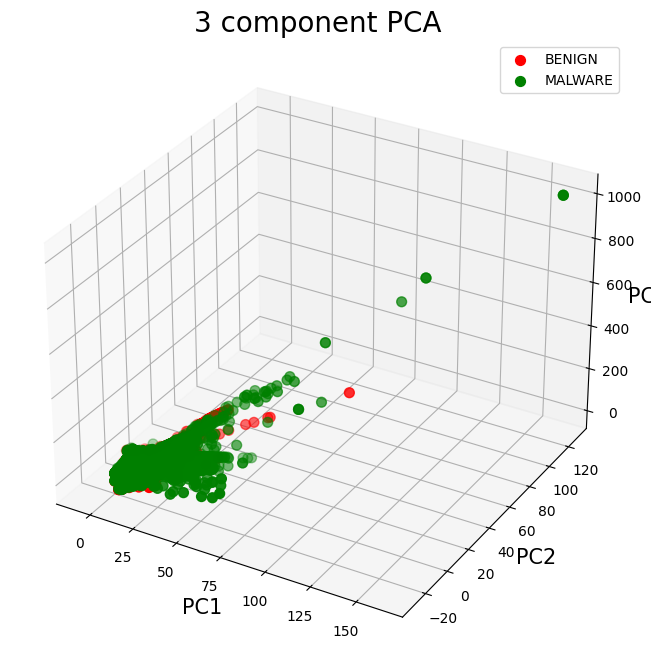

In [8]:
# PCA for 3 components and 3d plot
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3'])
finalDf = pd.concat([principalDf, df[['Label']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_zlabel('PC3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)

targets = ['BENIGN', 'MALWARE']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , finalDf.loc[indicesToKeep, 'PC3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

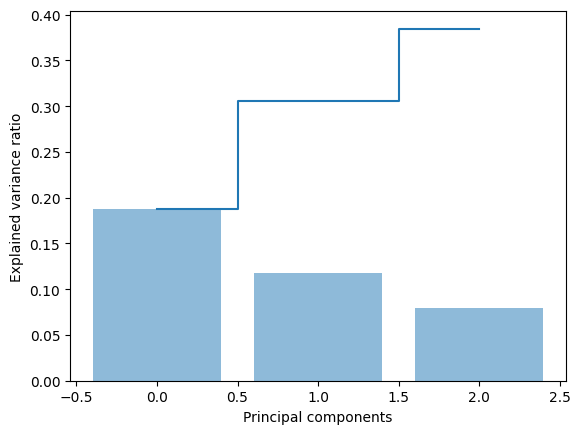

In [10]:
# Plot eigenvalues of first 3 components
plt.bar(range(3), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(3), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

In [18]:
df = pd.concat([principalDf, df[['Label']].reset_index(drop=True)], axis = 1)
df

,PC1,PC2,PC3,Label
0,0.190180,1.479716,-0.593988,BENIGN
1,-2.471925,0.155842,0.144903,BENIGN
2,-2.254003,0.166339,0.271628,BENIGN
3,-2.327667,0.126891,0.299635,BENIGN
4,-2.496800,-0.132783,0.215937,BENIGN
...,...,...,...,...
2616561,-2.119771,1.350585,-0.027438,MALWARE
2616562,1.851723,-9.914662,0.572002,MALWARE
2616563,-3.292346,-0.120106,0.458785,MALWARE
2616564,-1.559067,1.695740,-0.123620,MALWARE


# Data Information
Di seguito, le informazioni riassuntive della porzione di dataset considerata:

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2616566 entries, 0 to 2616565
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   PC1     float64
 1   PC2     float64
 2   PC3     float64
 3   Label   object 
dtypes: float64(3), object(1)
memory usage: 79.9+ MB


Alcune statistiche utili:

In [20]:
df.describe()

,PC1,PC2,PC3
count,2.616566e+06,2.616566e+06,2.616566e+06
mean,2.337549e-17,-3.966882e-17,-4.343258e-17
std,3.647953e+00,2.889640e+00,2.375006e+00
min,-7.359541e+00,-2.928468e+01,-1.065584e+01
25%,-2.385685e+00,-4.105147e-01,-4.419993e-01
50%,-2.000246e+00,1.637199e-01,2.605368e-03
75%,2.232898e+00,1.394713e+00,2.855461e-01
max,1.625395e+02,1.274586e+02,1.012238e+03


# Data visualization
Di seguito, alcuni plot che mostrano come sono distribuiti i dati:

<AxesSubplot: xlabel='Label', ylabel='# occurrences'>

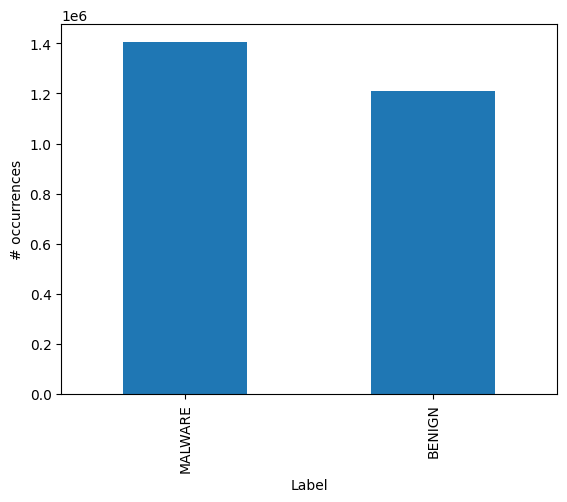

In [21]:
df["Label"].value_counts().plot(
    kind="bar",
    xlabel="Label",
    ylabel="# occurrences"
)

<AxesSubplot: ylabel='Label'>

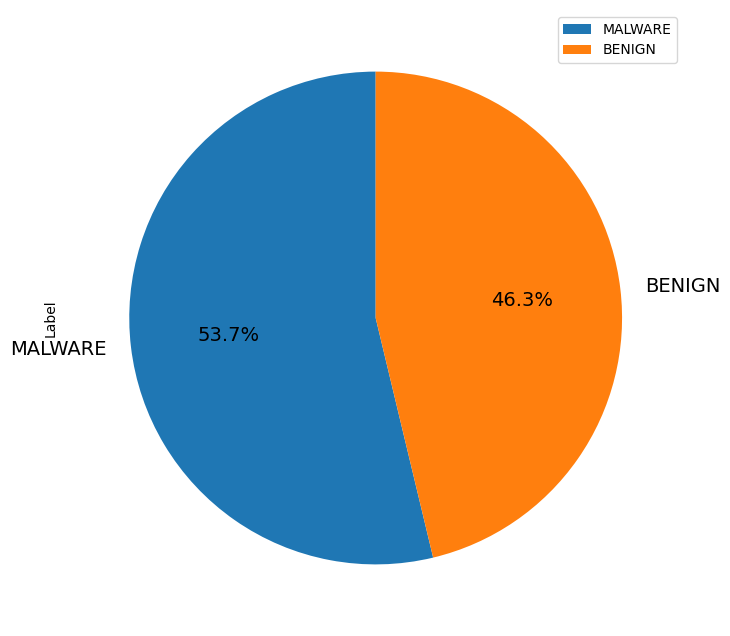

In [22]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

df["Label"].value_counts().plot(
    kind="pie",
    autopct='%1.1f%%',
    startangle=90,
    shadow=False,
    legend=True,
    fontsize=14,
    ax=ax
)

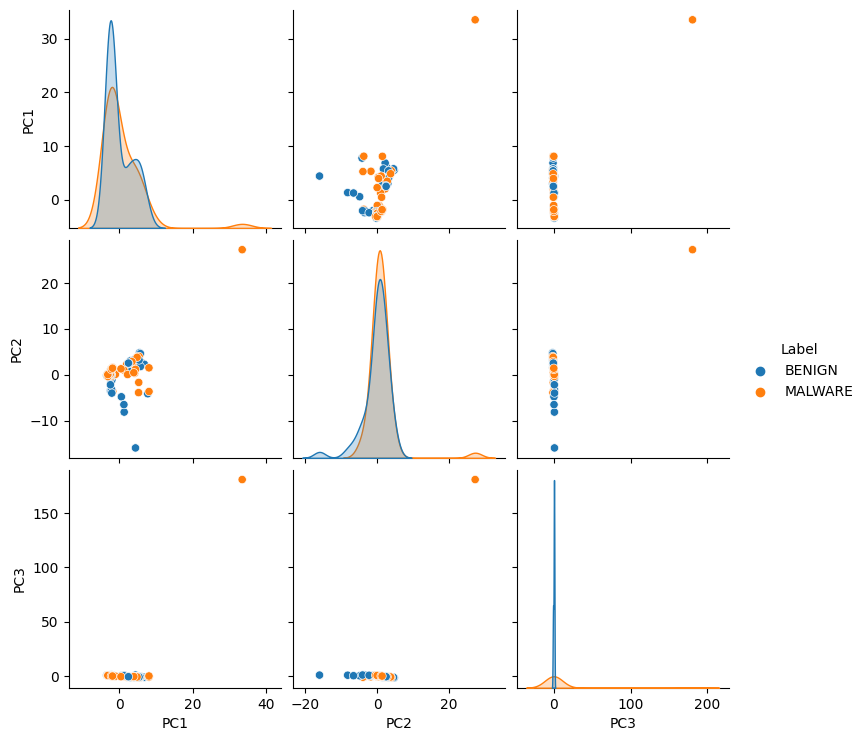

In [23]:
df = df.sample(frac=1).reset_index(drop=True)
sns.pairplot(df.iloc[:100], hue="Label")

# Data Preprocessing
Codifichiamo alcune informazioni non strutturate

In [6]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

def data_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    if "Source IP" in df.columns:
        df['Source IP'] = label_encoder.fit_transform(df['Source IP'])
    if "Flow ID" in df.columns:
        df['Flow ID'] = label_encoder.fit_transform(df['Flow ID'])
    if "Destination IP" in df.columns:
        df['Destination IP'] = label_encoder.fit_transform(df['Destination IP'])

    if "Timestamp" in df.columns:
        # drop column Timestamp
        df = df.drop(['Timestamp'], axis=1)    
    return df

df = data_preprocessing(df)
df

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,500630,22,45599.0,965,80.0,6.0,210533.0,3.0,4.0,401.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,500630,22,45599.0,965,80.0,6.0,142284.0,2.0,0.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,702275,22,48822.0,3297,443.0,6.0,37530.0,1.0,2.0,31.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,739237,22,39917.0,3345,443.0,6.0,36739.0,1.0,2.0,23.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,550724,22,54948.0,10032,80.0,6.0,289279.0,2.0,0.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2616574,112307,20,8300.0,43,53.0,17.0,400167.0,1.0,1.0,44.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MALWARE
2616575,761980,20,44967.0,3405,443.0,6.0,60072632.0,3.0,1.0,31.0,...,32.0,118314.0,0.0,118314.0,118314.0,59932174.0,0.0,59932174.0,59932174.0,MALWARE
2616576,180965,4068,443.0,44,39170.0,6.0,6714.0,2.0,1.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MALWARE
2616577,100944,20,55323.0,43,53.0,17.0,92288.0,1.0,1.0,30.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MALWARE


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Label'], axis=1),
    df['Label'],
    test_size=0.4,
    random_state=42
)

X_train.shape, X_test.shape

((1569939, 3), (1046627, 3))

In [25]:
X_train.head()

,PC1,PC2,PC3
474896,-3.120368,-0.050046,0.481764
1322895,0.999846,-6.169510,0.213866
862098,9.570135,5.592515,24.436492
1122717,-3.104397,0.048514,0.445443
1116575,9.216799,-6.603812,-1.016482


In [26]:
y_train.head()

474896      BENIGN
1322895    MALWARE
862098     MALWARE
1122717     BENIGN
1116575    MALWARE
Name: Label, dtype: object

# Valutazione
Di seguito, una funzione per valutare le performance di un modello ed una funzione per stampare la relativa matrice di confusione

In [27]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label'
    )
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha='right',
        rotation_mode='anchor'
    )
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    return ax

def valuate(clf, x_test, y_test):
    y_pred = clf.predict(x_test)
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, classes=clf.classes_, title='Confusion matrix')


# Decision Tree

Il Decision Tree (albero decisionale) è un modello di machine learning che rappresenta una serie di decisioni e condizioni logiche per classificare i dati. 

In questo progetto, viene utilizzato un Decision Tree per analizzare il traffico di rete delle applicazioni e identificare i pattern caratteristici delle applicazioni malware. Ogni nodo dell'albero rappresenterebbe una condizione o una caratteristica del traffico di rete, consentendo al modello di prendere decisioni sulla classificazione delle applicazioni in base alle loro caratteristiche di traffico. Questo approccio può fornire una visione trasparente e interpretabile dei processi decisionali nel rilevamento delle applicazioni malware, consentendo una migliore comprensione delle caratteristiche distintive del traffico dannoso.

In [28]:
from sklearn import tree
decision_tree = tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train, y_train)

[Text(0.5, 0.875, 'PC1 <= -2.524\ngini = 0.497\nsamples = 1569939\nvalue = [725817, 844122]\nclass = MALWARE'),
 Text(0.25, 0.625, 'PC1 <= -3.174\ngini = 0.5\nsamples = 284606\nvalue = [145156, 139450]\nclass = BENIGN'),
 Text(0.125, 0.375, 'PC1 <= -3.34\ngini = 0.483\nsamples = 37440\nvalue = [15245, 22195]\nclass = MALWARE'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'PC2 <= -0.259\ngini = 0.499\nsamples = 247166\nvalue = [129911, 117255]\nclass = BENIGN'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'PC2 <= 1.904\ngini = 0.495\nsamples = 1285333\nvalue = [580661, 704672]\nclass = MALWARE'),
 Text(0.625, 0.375, 'PC3 <= -0.102\ngini = 0.493\nsamples = 1030895\nvalue = [455021, 575874]\nclass = MALWARE'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'PC1 <= 8.413\ngini = 0.5\nsamples = 254438\nvalue = [125640, 128798]\nclass =

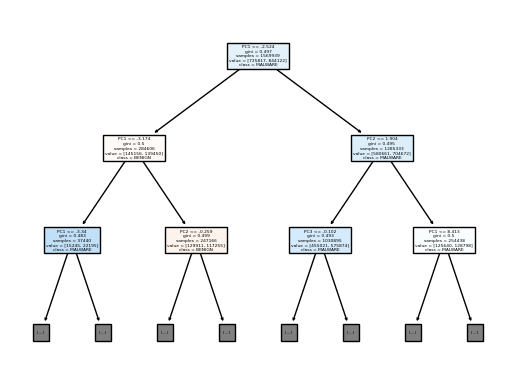

In [29]:
tree.plot_tree(decision_tree, filled=True, class_names=decision_tree.classes_, feature_names=X_train.columns, max_depth=2)

              precision    recall  f1-score   support

      BENIGN       0.59      0.57      0.58    484392
     MALWARE       0.64      0.65      0.65    562235

    accuracy                           0.62   1046627
   macro avg       0.61      0.61      0.61   1046627
weighted avg       0.61      0.62      0.62   1046627



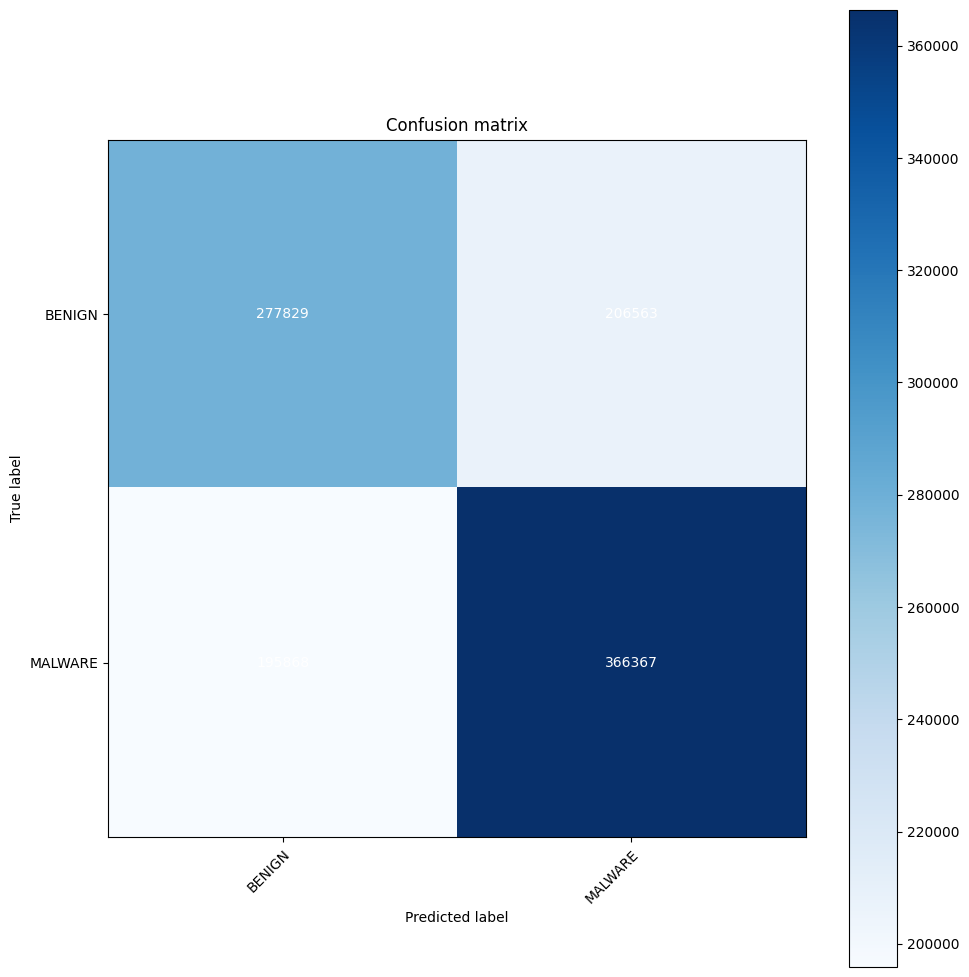

In [30]:
valuate(decision_tree, X_test, y_test)

In [17]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    decision_tree,
    X_train,
    y_train,
    cv=10,
    scoring=['precision_macro', 'recall_macro']
)

In [21]:
print(f'{10}-fold cross validation:')
print('Precision: %0.2f (+/- %0.2f)' % (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std() * 2))
print('Recall: %0.2f (+/- %0.2f)' % (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std() * 2))

10-fold cross validation:
Precision: 0.62 (+/- 0.00)
Recall: 0.62 (+/- 0.00)


# Random Forest

Random Forest è un modello di machine learning basato su un insieme di alberi decisionali. 

Nel progetto, utilizziamo un Random Forest per analizzare il traffico di rete delle applicazioni e rilevare i modelli distintivi delle applicazioni malware. L'ensemble di alberi decisionali nel Random Forest lavora in parallelo per classificare il traffico di rete in modo accurato e robusto. Questo modello può essere efficace nel riconoscere le caratteristiche del traffico delle applicazioni malware, combattendo l'overfitting e fornendo una maggiore generalizzazione rispetto a un singolo albero decisionale. Random Forest può contribuire a migliorare la precisione e l'affidabilità dell'analisi del traffico di rete per la distinzione tra applicazioni malware e legali.

              precision    recall  f1-score   support

      BENIGN       0.62      0.59      0.61    484392
     MALWARE       0.66      0.69      0.68    562235

    accuracy                           0.65   1046627
   macro avg       0.64      0.64      0.64   1046627
weighted avg       0.64      0.65      0.64   1046627



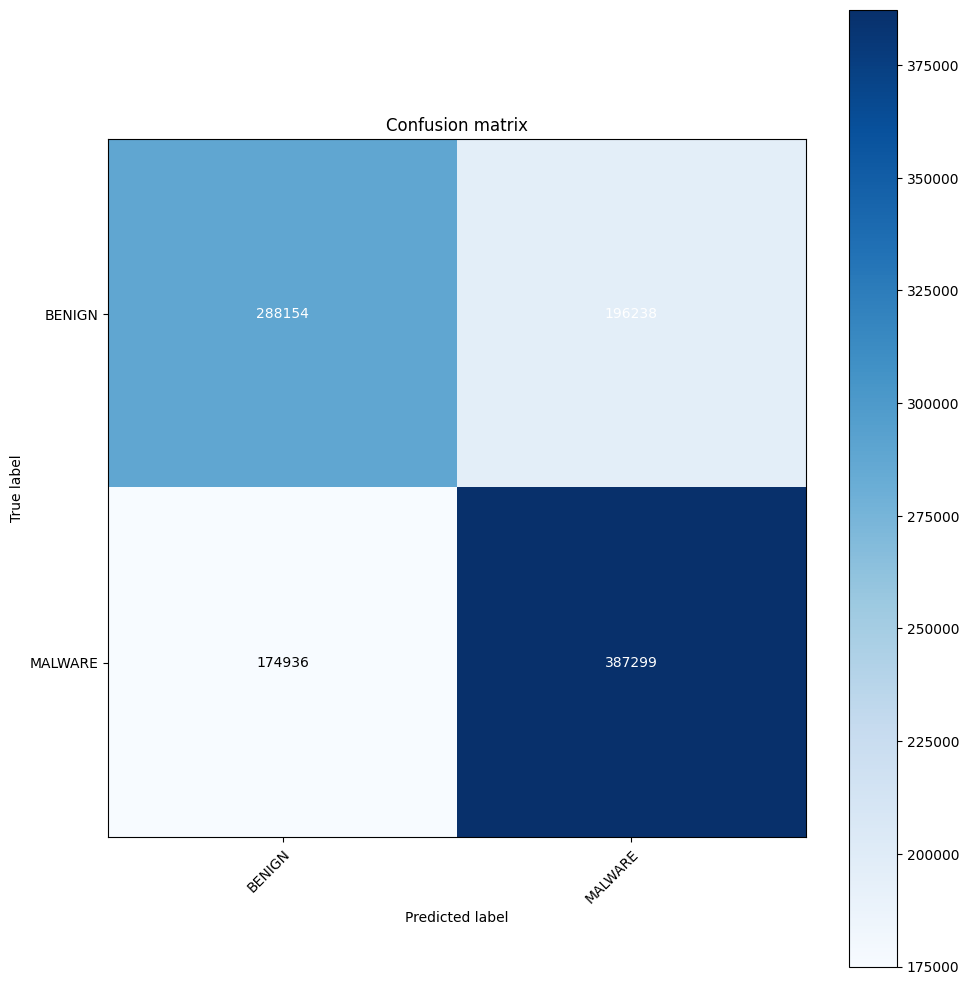

In [31]:
# Classify using Random Forest
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)

valuate(random_forest, X_test, y_test)

# Adaboost

AdaBoost (Adaptive Boosting) è un modello di machine learning che combina diversi classificatori deboli in un classificatore forte. 

Nel progetto, vorremmo utilizzare AdaBoost per analizzare il traffico di rete delle applicazioni e individuare i modelli distintivi delle applicazioni malware. L'AdaBoost assegna pesi diversi ai campioni di addestramento in base alla loro difficoltà di classificazione, concentrandosi maggiormente sui campioni classificati erroneamente. Ciò consente di migliorare progressivamente la capacità del modello di identificare correttamente il traffico di rete associato alle applicazioni malware. L'AdaBoost può fornire un'analisi del traffico di rete più accurata e robusta, rafforzando la capacità di rilevamento delle applicazioni dannose e migliorando la sicurezza complessiva del sistema.

              precision    recall  f1-score   support

      BENIGN       0.54      0.29      0.38    484392
     MALWARE       0.56      0.78      0.66    562235

    accuracy                           0.56   1046627
   macro avg       0.55      0.54      0.52   1046627
weighted avg       0.55      0.56      0.53   1046627



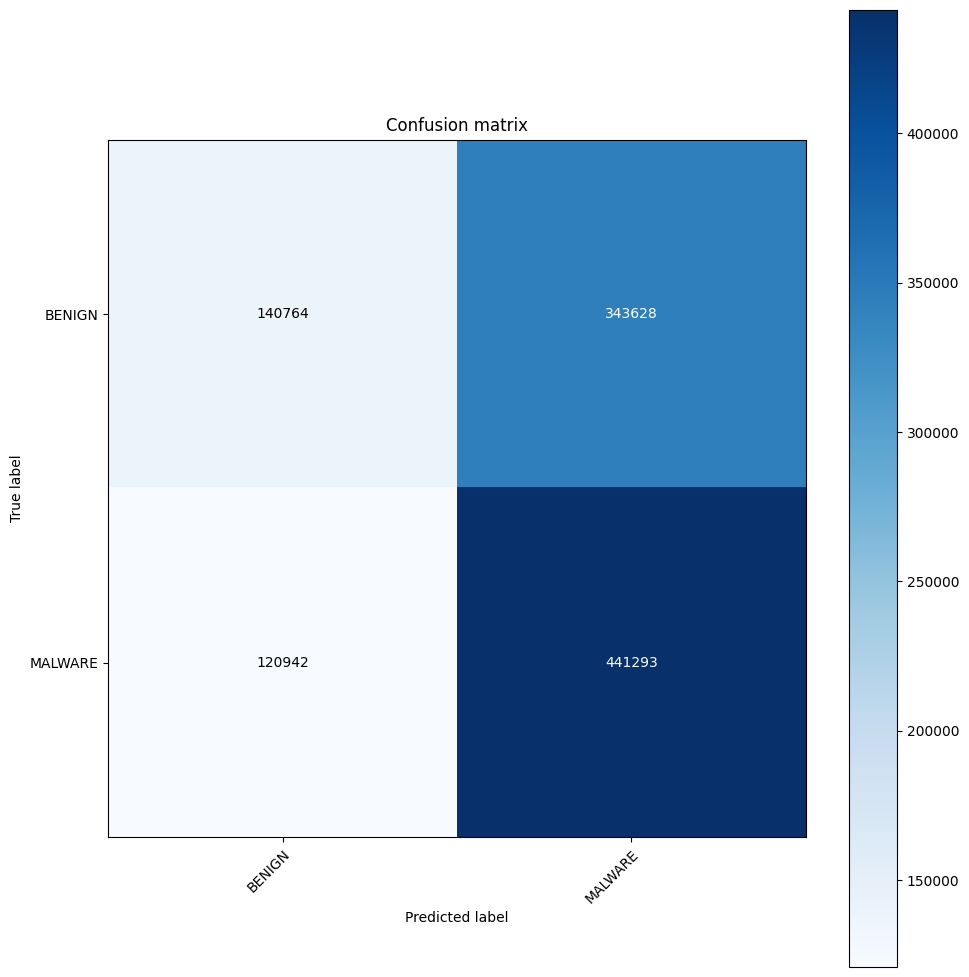

In [33]:
# Classify using Adaboost
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(n_estimators=100)
adaboost.fit(X_train, y_train)

valuate(adaboost, X_test, y_test)

# Gradient boosting

Il Gradient Boosting è un modello di machine learning che combina diversi modelli di alberi decisionali in un processo iterativo, consentendo di ottenere una migliore precisione predittiva. 
Nel progetto, vorremmo utilizzare il Gradient Boosting per analizzare il traffico di rete delle applicazioni e identificare i pattern caratteristici delle applicazioni malware. Il modello incrementale del Gradient Boosting consente di migliorare progressivamente la capacità di classificazione del traffico di rete, imparando dai propri errori precedenti e mettendo maggiormente l'accento sui casi più difficili da classificare. Questo approccio può portare a una maggiore precisione e sensibilità nel rilevamento delle applicazioni malware, consentendo un'analisi più accurata e affidabile del traffico di rete.

              precision    recall  f1-score   support

      BENIGN       0.56      0.27      0.36    484392
     MALWARE       0.56      0.82      0.67    562235

    accuracy                           0.56   1046627
   macro avg       0.56      0.54      0.51   1046627
weighted avg       0.56      0.56      0.53   1046627



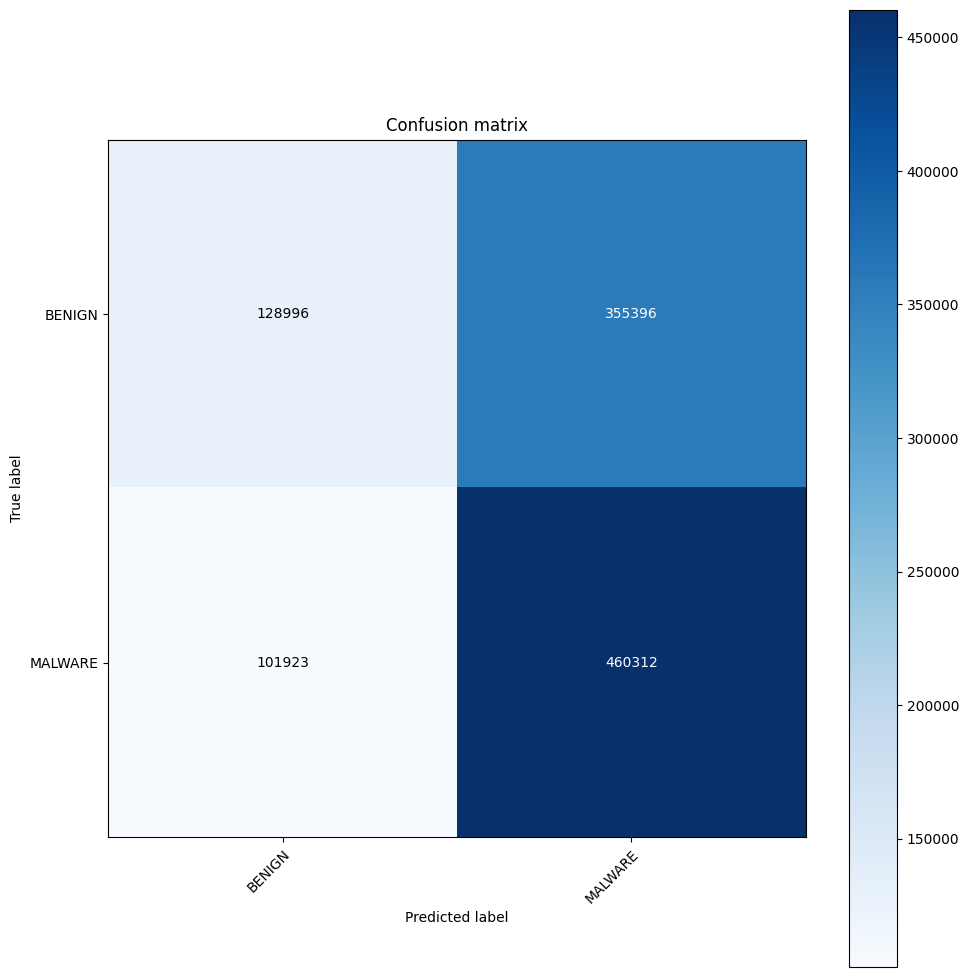

In [32]:
# Classify using Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting = GradientBoostingClassifier(n_estimators=100)
gradient_boosting.fit(X_train, y_train)

valuate(gradient_boosting, X_test, y_test)

# KNN

Il modello di machine learning K-Nearest Neighbors (KNN) è un algoritmo semplice ma potente che si basa sull'idea che gli oggetti simili tendono ad essere vicini nello spazio delle features. Nell'ambito del progetto di classificazione di malware Android, KNN può essere utilizzato per identificare il traffico di rete di malware in base alle sue caratteristiche e all'analisi del traffico di applicazioni simili in un vicinato definito. Questo modello offre un approccio intuitivo e può essere particolarmente utile per identificare nuove varianti di traffico di malware basandosi sulle similarità con esempi noti.

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

              precision    recall  f1-score   support

      BENIGN       0.56      0.53      0.54      4654
     MALWARE       0.61      0.63      0.62      5346

    accuracy                           0.58     10000
   macro avg       0.58      0.58      0.58     10000
weighted avg       0.58      0.58      0.58     10000



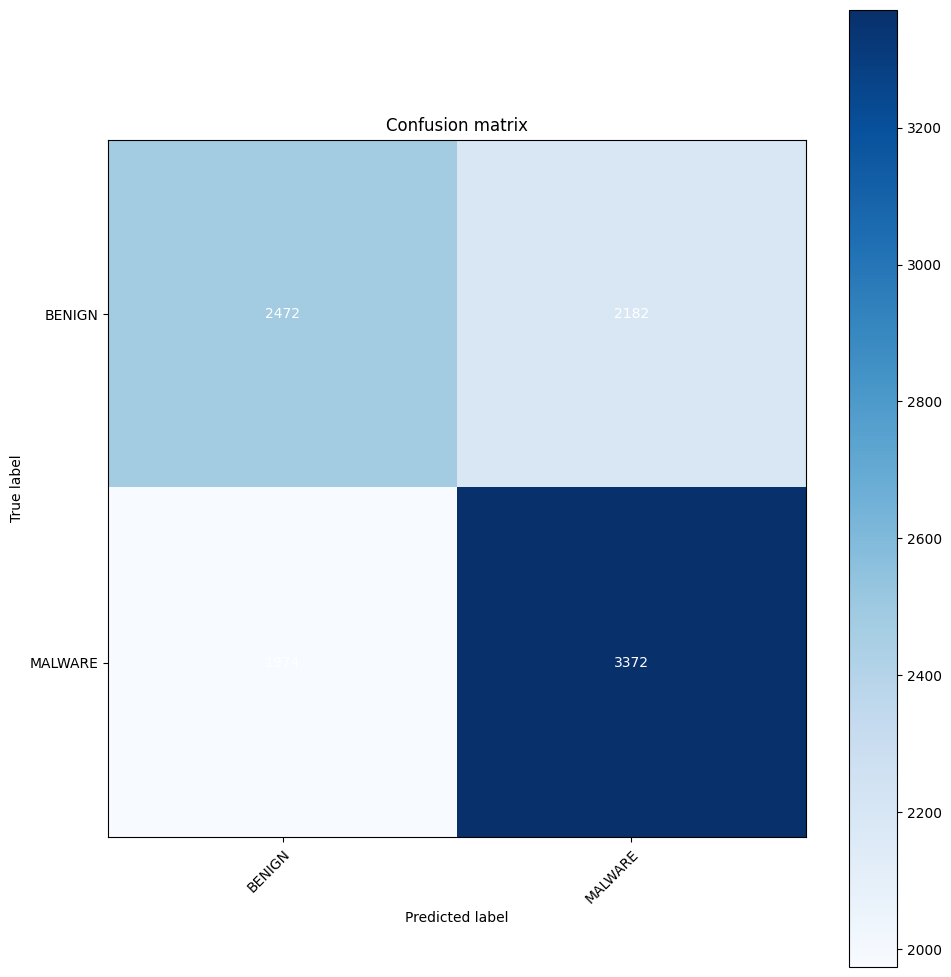

In [27]:
valuate(knn, X_test[:10_000], y_test[:10_000])

# Support Vector Machine

Support Vector Machine (SVM) è un modello di machine learning ampiamente utilizzato nella classificazione di dati binari, come il rilevamento di malware. Grazie alla sua capacità di creare iperpiani ottimali per separare i dati in due classi, SVM potrebbe essere particolarmente utile in questo progetto per identificare i modelli distintivi dei malware Android e distinguere le applicazioni legittime da quelle dannose, garantendo una maggiore precisione nella classificazione.

In [30]:
C=1.0
models = (
    # svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=100, dual=True),
    svm.SVC(kernel="rbf", gamma=0.7, C=C, max_iter=100),
    #svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
)
models = [clf.fit(X_train, y_train) for clf in models]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


LinearSVC:
              precision    recall  f1-score   support

      BENIGN       0.43      0.37      0.40    483989
     MALWARE       0.51      0.57      0.54    562639

    accuracy                           0.48   1046628
   macro avg       0.47      0.47      0.47   1046628
weighted avg       0.47      0.48      0.47   1046628

SVC:
              precision    recall  f1-score   support

      BENIGN       0.46      1.00      0.63    483989
     MALWARE       0.37      0.00      0.00    562639

    accuracy                           0.46   1046628
   macro avg       0.42      0.50      0.32   1046628
weighted avg       0.41      0.46      0.29   1046628



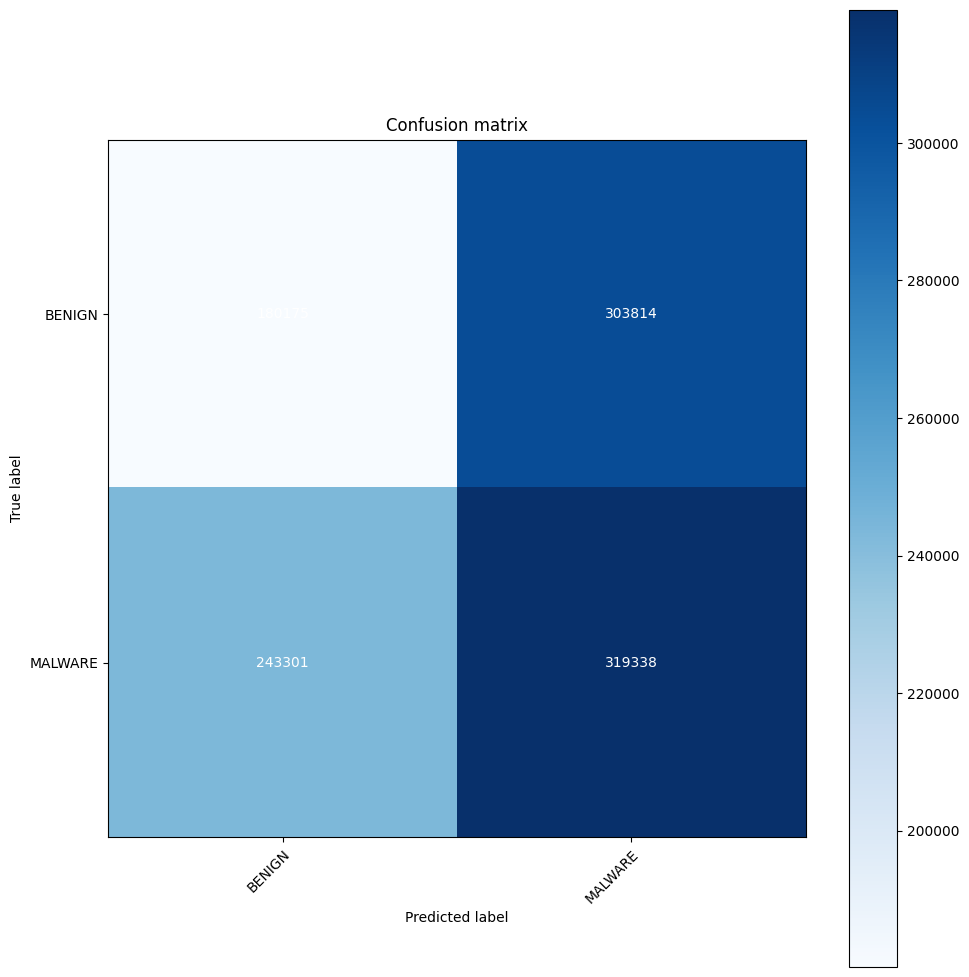

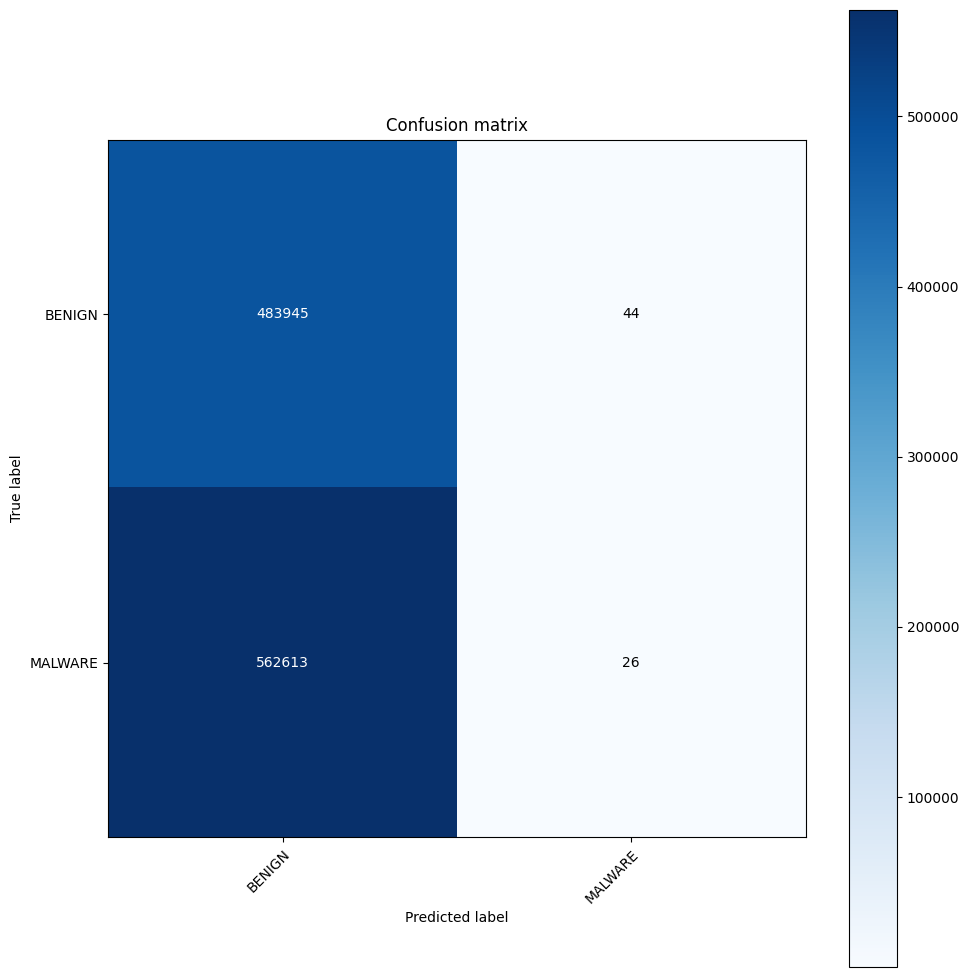

In [31]:
# valuate models

for clf in models:
    # print scores 
    print(f'{clf.__class__.__name__}:')
    valuate(clf, X_test, y_test)

# Logistic Regression

La Logistic Regression (Regressione Logistica) è un modello di machine learning utilizzato per la classificazione binaria. 

Nel progetto, vorremmo utilizzare la Logistic Regression per analizzare il traffico di rete delle applicazioni e classificare se sono malware o legali. Questo modello calcola la probabilità che un dato campione di traffico di rete appartenga a una determinata classe, consentendo di distinguere tra il traffico associato a malware e quello legale. La Logistic Regression è particolarmente utile quando si desidera ottenere una spiegazione interpretabile delle decisioni di classificazione, in quanto fornisce i coefficienti che indicano l'importanza relativa delle caratteristiche del traffico di rete nella predizione. Questo modello può essere un'opzione efficace per l'analisi del traffico di rete e la classificazione delle applicazioni nel progetto.

In [32]:
from sklearn.linear_model import LogisticRegression

logistic_classifier = LogisticRegression(random_state=0, max_iter=100).fit(X_train, y_train)

              precision    recall  f1-score   support

      BENIGN       0.33      0.01      0.01    483989
     MALWARE       0.54      0.99      0.70    562639

    accuracy                           0.53   1046628
   macro avg       0.43      0.50      0.35   1046628
weighted avg       0.44      0.53      0.38   1046628



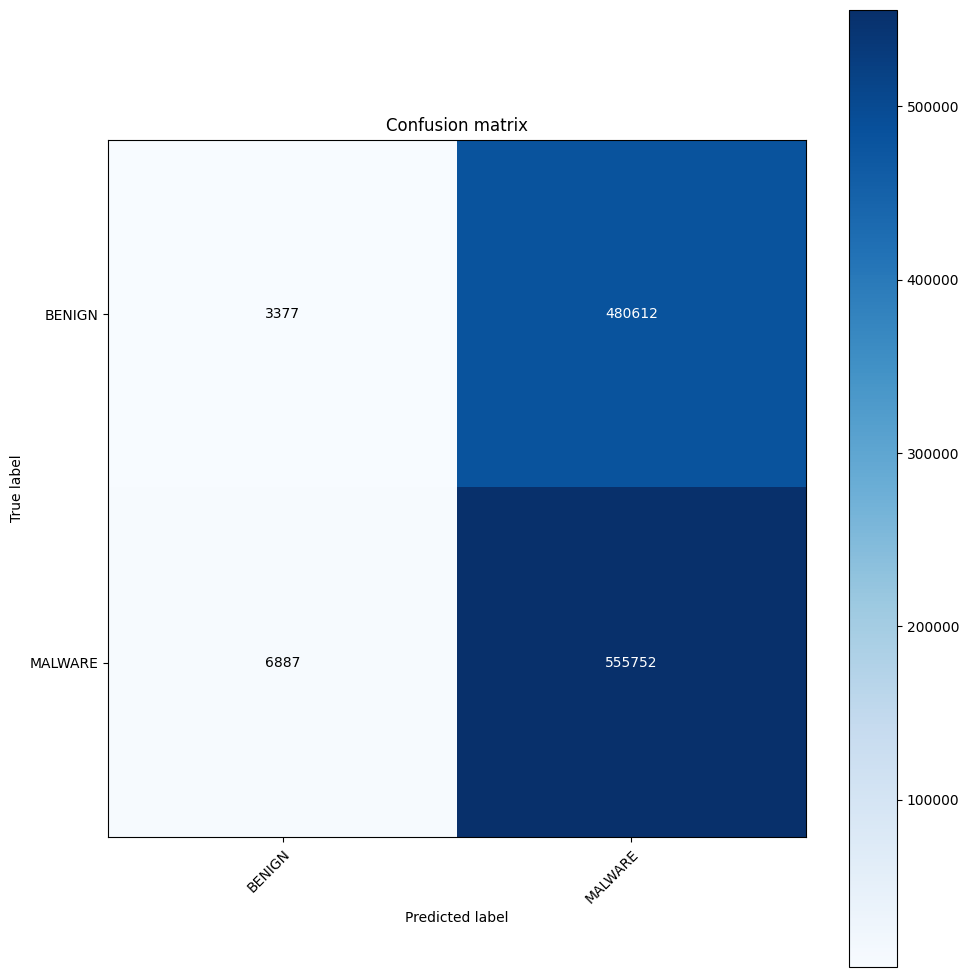

In [33]:
valuate(logistic_classifier, X_test, y_test)

# Gaussian Discriminant Analysis

Gaussian Discriminant Analysis (GDA) è un modello di machine learning che assume che i dati siano distribuiti secondo una distribuzione gaussiana. 

Nel progetto, vorremmo utilizzare GDA per analizzare il traffico di rete delle applicazioni e distinguere tra malware e applicazioni legali. Il GDA stima i parametri delle distribuzioni gaussiane associate a ciascuna classe e utilizza queste informazioni per calcolare le probabilità a posteriori di appartenenza a una determinata classe. Questo modello è particolarmente adatto quando le classi sono ben separate e possono essere approssimate da distribuzioni gaussiane. Il GDA può essere utilizzato per rilevare i pattern caratteristici del traffico di rete delle applicazioni malware, fornendo una valutazione delle probabilità di appartenenza a ciascuna classe e facilitando la classificazione delle applicazioni in base a tali probabilità.

In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_classifier = LinearDiscriminantAnalysis().fit(X_train, y_train)

              precision    recall  f1-score   support

      BENIGN       0.42      0.01      0.02    483989
     MALWARE       0.54      0.99      0.70    562639

    accuracy                           0.54   1046628
   macro avg       0.48      0.50      0.36   1046628
weighted avg       0.48      0.54      0.38   1046628



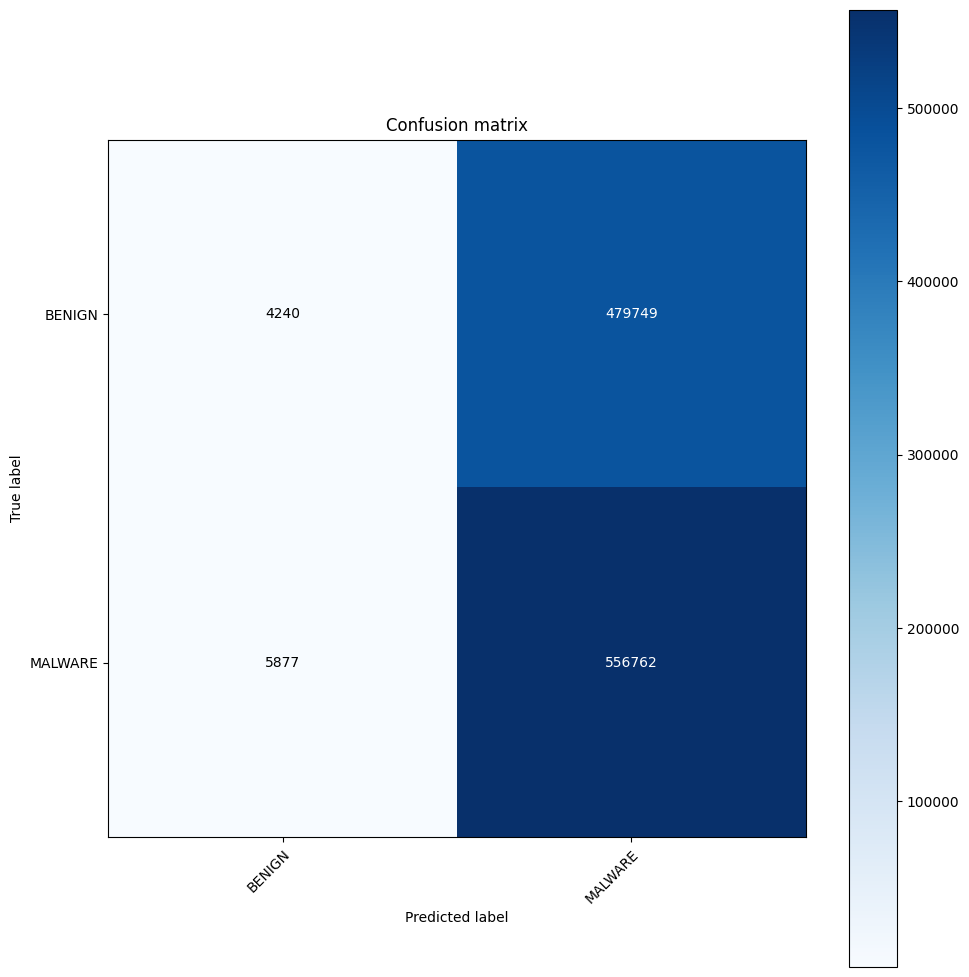

In [36]:
valuate(lda_classifier, X_test, y_test)

# MultiLayer Perceptron

Multilayer Perceptron (MLP) è un tipo di rete neurale artificiale composta da uno o più strati nascosti di neuroni interconnessi. 

Nel progetto, vorremmo utilizzare MLP per analizzare il traffico di rete delle applicazioni e identificare i modelli distintivi delle applicazioni malware. L'MLP è in grado di apprendere in modo non lineare i complessi pattern presenti nei dati del traffico di rete. Attraverso l'addestramento con un ampio set di dati etichettati, il MLP può imparare a riconoscere le caratteristiche del traffico di rete associate alle applicazioni malware e generare una classificazione accurata. Questo modello offre una flessibilità nel rappresentare le relazioni complesse tra le caratteristiche del traffico di rete e la classe di appartenenza delle applicazioni, rendendolo una scelta potente per l'analisi e la classificazione del traffico di rete nel progetto.

In [37]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    print("Change the options of this Notebook to use the GPU instead for a quicker execution and re-run the notebook!")
    device = torch.device("cpu")

No GPU available, using the CPU instead.
Change the options of this Notebook to use the GPU instead for a quicker execution and re-run the notebook!


In [38]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(y):
    y = y.values.reshape(-1, 1)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
    y = ohe.transform(y)
    return y


X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(one_hot_encoding(y_train), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(one_hot_encoding(y_test), dtype=torch.float32)

In [39]:
from torch.utils.data import Dataset, DataLoader

class NetworkDataset(Dataset):
    def __init__(self, data, target):
        self.data = data.to_numpy()
        #self.data = data
        self.target = label_encoder.fit_transform(target)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]


train_dataset = NetworkDataset(X_train, y_train)
test_dataset = NetworkDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [40]:
import torch.nn as nn
import torch.nn.functional as F

class NetworkNN(nn.Module):

    def __init__(self):
        super(NetworkNN, self).__init__()
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 5)
        self.fc3 = nn.Linear(5, 2)
        self.logits = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.logits(x)
        return x

model = NetworkNN()

In [41]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, dataloader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1} loss: {running_loss / len(dataloader)}')

In [42]:
train(model, train_dataloader, criterion, optimizer, epochs=10)

Epoch 1 loss: 101.34392438190827
Epoch 2 loss: 0.6903742618573621
Epoch 3 loss: 0.6903768166396111
Epoch 4 loss: 0.6903798979963744
Epoch 5 loss: 0.690372081252133
Epoch 6 loss: 0.6903732041063527
Epoch 7 loss: 0.6903824038066446
Epoch 8 loss: 0.6903761389723886
Epoch 9 loss: 0.6903721644814145
Epoch 10 loss: 0.6903772702433254


In [43]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for _ in range(2))
class_total = list(0. for _ in range(2))

model.eval() # prep model for *evaluation*

for data, target in test_dataloader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.float())
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.690322

Test Accuracy of     0:  0% ( 0/483989)
Test Accuracy of     1: 100% (562639/562639)

Test Accuracy (Overall): 53% (562639/1046628)
